# Predictive Analysis on Insurance 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from imblearn.over_sampling import SMOTE

In [4]:
# Load the dataset
data = pd.read_csv("train.csv")

# Display the first few rows of the dataset
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Note: We do not use regressor algorithms(class 2 and 3) in our task since our response variable is categorical 0 and 1. Also, our dataset does not contain any columns that have text(sentences) values, we do not use the NLP knowledge in the class 5.

# Introduction
#### Our case study is to assist the Insurance company in building a predictive model to determine which customers are interested in buying their product. This model enables the company to effectively assess and evaluate in their investment strategies to target those customers.

Data source: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv

The dataset contains the following columns:

id: The unique identifier for each customer.

Gender: The gender of the customer.

Age: The age of the customer.

Driving_License: Whether the customer has a driving license (1 if Yes, 0 if No).

Region_Code: The code for the region of the customer.

Previously_Insured: Whether the customer was previously insured (1 if Yes, 0 if No).

Vehicle_Age: The age of the vehicle.

Vehicle_Damage: Whether the vehicle has been damaged before (Yes if it has, No if it hasn't).

Annual_Premium: The amount of the annual premium for the customer.

Policy_Sales_Channel: The sales channel through which the policy was sold.

Vintage: The number of days the customer has been associated with the company.

Response: Whether the customer is interested in purchasing vehicle insurance (1 if interested, 0 if not interested).

In [297]:
data_copy = pd.read_csv("train.csv")
le = LabelEncoder()
data_copy['Vehicle_Damage'] = le.fit_transform(data_copy['Vehicle_Damage'])
data_copy['Vehicle_Age'] = le.fit_transform(data_copy['Vehicle_Age'])
data_copy['Gender'] = le.fit_transform(data_copy['Gender'])
data_copy = data_copy.drop(columns=["id"])

array([[<AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Driving_License'}>],
       [<AxesSubplot:title={'center':'Region_Code'}>,
        <AxesSubplot:title={'center':'Previously_Insured'}>,
        <AxesSubplot:title={'center':'Vehicle_Age'}>],
       [<AxesSubplot:title={'center':'Vehicle_Damage'}>,
        <AxesSubplot:title={'center':'Annual_Premium'}>,
        <AxesSubplot:title={'center':'Policy_Sales_Channel'}>],
       [<AxesSubplot:title={'center':'Vintage'}>,
        <AxesSubplot:title={'center':'Response'}>, <AxesSubplot:>]],
      dtype=object)

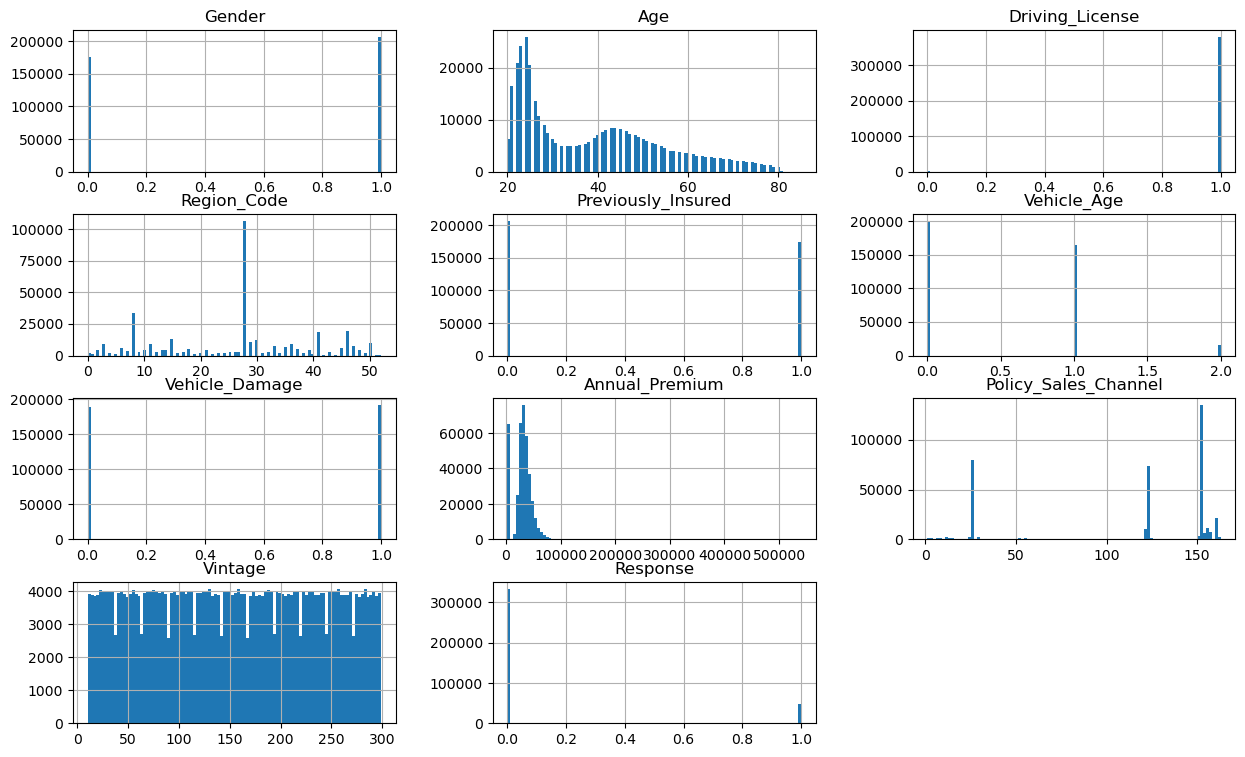

In [298]:
data_copy.hist(bins=100, figsize=(15, 9))

The Ages are mainly distributed at around 25 and 45 as two peaks. Also, the Annual_premiums are mostly distributed around at 50000 and at 0.

Almost all of the customers have a driving license, and the Responses are unbalanced, most of them are 1. 

The gender, previous, driving license, previously insured, vehicle age and vehicle damage are categorical variables.

In [7]:
# Check for missing values in each column
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Since there are some categorical variables which should be converted into numerical ones, we choose to use one-hot encoding for 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured' and 'Vehicle_Age' since it has an inherent order.

## Data processing and dealing with unbalanced data

The dataset is imbalanced, with the number of customers who did not buy car insurance (response = 0) significantly outnumbering those who did (response = 1). This imbalance can lead to models that have poor predictive performance for the minority class, which is often the class of interest. SMOTE can help address this imbalance by creating synthetic examples of the minority class.

It can introduce noise by creating synthetic examples that are not representative of true instances. Moreover, it does not take into account the potential overlap between classes. Therefore, it's always a good idea to try multiple strategies for dealing with imbalance and to validate the model's performance using a separate test set.

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321-357. This is the original paper that introduced SMOTE

https://jair.org/index.php/jair/article/view/10302

In [208]:
data = pd.read_csv("train.csv")
# Drop 'id' column
# data = data[['Vehicle_Damage', 'Age', 'Previously_Insured',"Annual_Premium", 'Region_Code', 'Response', 'Driving_License']]
data = data.drop(columns=["id"])

# Apply one-hot encoding to 'Gender' and 'Vehicle_Age'
data = pd.get_dummies(
    data,
    columns=[
        "Gender",
        "Vehicle_Age",
        "Vehicle_Damage",
        "Previously_Insured",
        "Driving_License",
    ],
)
# data = pd.get_dummies(data, columns=['Vehicle_Damage', 'Previously_Insured', 'Driving_License'])

# Separate the response variable 'Response'
y = data["Response"]
X = data.drop(["Response"], axis=1)
data_copy2 = data.drop(columns=["Response"])

# Split the data into training, validation, and test sets (70-15-15 split), 
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=222
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=222
)


# Initialize SMOTE
smote = SMOTE(random_state=222)

# Fit SMOTE on the training data only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Example result for unbalanced data without using the SMOTE method

Class 0 (those who did not purchase insurance) has a very high precision of 0.88, which means that when the model predicts that a customer will not purchase insurance, it is accurate 88% of the time. The precision for class 1 (those who actually purchased insurance) is low at 0.38, which means that the customer who want to purchase insurance again only takes 38% of our prediction for class 1.

Recall for class 0 is 1.00, indicating that all non-buying customers were correctly identified by the model. However, Class 1's recall is almost 0, indicating that the model has a very difficult time correctly identifying customers who actually purchased insurance.

 The model is good at predicting customers who will not buy insurance, but very bad at predicting customers who will. Therefore, the SMOTE is required.

In [227]:
unbalanced_dt_model = DecisionTreeClassifier(random_state=222)
unbalanced_dt_model.fit(X_train, y_train)
unbalanced_dt_y_test_pred = unbalanced_dt_model.predict(X_test)
print("Decision Tree classifier: \n", classification_report(y_test, unbalanced_dt_y_test_pred))

Decision Tree classifier: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     50176
           1       0.38      0.00      0.00      6991

    accuracy                           0.88     57167
   macro avg       0.63      0.50      0.47     57167
weighted avg       0.82      0.88      0.82     57167



# Decision tree and random forest models

In these two models, we use all the features from the data set. The decision tree model is our baseline model.
Then, we create a random forest model to compare with it.

 Also, the tree models do not require scaling the data since the decision-making process in tree models is based on splitting the data at each node based on a selected feature and a threshold value. This split criterion, such as Gini impurity or information gain, relies only on the relative ordering of the feature values and does not depend on their absolute magnitudes.

In [184]:
# Initialize classifiers
dt_model = DecisionTreeClassifier(random_state=222) # baseline model
rdf_model = RandomForestClassifier(random_state=222) # non tuned

# Train the model
dt_model.fit(X_train_smote, y_train_smote)
rdf_model.fit(X_train_smote, y_train_smote)

# Use the models to make predictions on the test data
dt_y_test_pred = dt_model.predict(X_test)
rdf_y_test_pred = rdf_model.predict(X_test)

# Calculate the performance metrics of the model on the test data
print("Decision Tree classifier: \n", classification_report(y_test, dt_y_test_pred))
print("Random forest classifier: \n", classification_report(y_test, rdf_y_test_pred))

Decision Tree classifier: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     50176
           1       0.28      0.33      0.30      6991

    accuracy                           0.82     57167
   macro avg       0.59      0.61      0.60     57167
weighted avg       0.83      0.82      0.82     57167

Random forest classifier: 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     50176
           1       0.33      0.31      0.32      6991

    accuracy                           0.84     57167
   macro avg       0.62      0.61      0.62     57167
weighted avg       0.84      0.84      0.84     57167



# Basic decision tree and random forest model results after applying SMOTE method

After we used the SMOTE method to deal with the unbalanced data, the recall for both models increased.

Since we are interested in correctly identifying the customers who would buy car insurance (labelled as 1 in the dataset).
The performance of the Decision Tree and Random Forest classifiers is not as good when it comes to identifying potential purchasers (class 1), despite the fact that the overall accuracy appears to be rather strong (0.82 for Decision Tree and 0.84 for Random Forest).


Precision and recall for class 1 are the main metrics to consider here:


1. Precision informs us of the percentage of clients who were considered potential purchasers and who actually purchased insurance. This is 0.28 for Decision Tree and 0.33 for Random Forest. These numbers are low, indicating that a sizeable portion of the people we target based on the projections of the model would not really purchase the insurance.


2. Recall reveals how many genuine buyers we were able to match up with our model. This is 0.33 for Decision Tree and 0.31 for Random Forest. Once more, these values are low, which shows that we under-serve a sizable portion of the market with our models.


In conclusion, even if the models' overall accuracy is acceptable, they struggle to identify potential insurance purchasers, which is the task that matters the most to us. The aforementioned problems must be resolved, perhaps by enhancing feature selection, adjusting the maximum depth and changing the sample leaf and split. 

### Therefore, we create a hyperparameter tuners for this random forest model.


In [196]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [4, 5, 6],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
}

# Initialize the Random Forest Classifier
rdf_model = RandomForestClassifier(random_state=222) # tuned model

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rdf_model, param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Use the best model for prediction
best_rdf_model = grid_search.best_estimator_
y_pred = best_rdf_model.predict(X_test)

Best Hyperparameters:  {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [197]:
best_rdf_model

RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=150,
                       random_state=222)

##  Result of the tuned random forest model

The tuned Random Forest model has a much higher recall for class 1 (0.85) compared to the previous Decision Tree (0.33) and Random Forest models (0.31). The tuned model is much better at predicting customers who would buy insurance, meaning it is able to correctly identify 85% of the insurance buyers and the model will miss fewer potential customers who are likely to purchase insurance. This insight is extremely valuable for a business looking to target potential customers effectively and efficiently for doing targeted advertisement.

In comparison to the prior Decision Tree (0.82) and Random Forest models (0.84), the overall accuracy is lower in the tuned Random Forest model (0.73). But in this situation, it's not necessarily a problem. Accuracy is not the best indicator of model performance due to the unbalanced nature of the data. The tuned Random Forest model's strong recall demonstrates that it is doing well on the minority class (insurance clients).

In [199]:
print("Random forest classifier: \n", classification_report(y_test, y_pred))

Random forest classifier: 
               precision    recall  f1-score   support

           0       0.97      0.72      0.83     50176
           1       0.30      0.85      0.44      6991

    accuracy                           0.73     57167
   macro avg       0.63      0.78      0.63     57167
weighted avg       0.89      0.73      0.78     57167



# ROC and AUC curves results:
Decision Tree Model (AUC = 0.61): An AUC score of 0.61 is slightly better than a random guess (which would have an AUC of 0.5). This indicates that your Decision Tree model has some predictive power, but it's relatively weak. In other words, the model is able to rank a randomly chosen positive instance (customer who buys insurance) higher than a randomly chosen negative instance (customer who doesn't buy insurance) about 61% of the time.

Tuned Random Forest Model (AUC = 0.84): An AUC score of 0.84 is considered good and suggests that your tuned Random Forest model has strong predictive power. This model can rank a randomly chosen positive instance higher than a randomly chosen negative instance about 84% of the time.

In conclusion, the tuned Random Forest model(AUC = 0.84) outperforms the Decision Tree(AUC = 0.61) model by a large margin when it comes to predicting whether or not a consumer will purchase insurance. 

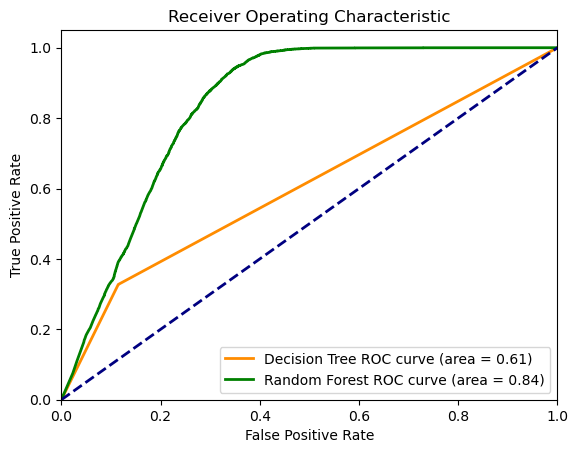

In [200]:
# Use the models to make probability predictions on the test data
dt_y_test_pred_prob = dt_model.predict_proba(X_test)[
    :, 1
]  # probabilities for the positive outcome
rdf_y_test_pred_prob = best_rdf_model.predict_proba(X_test)[
    :, 1
]  # probabilities for the positive outcome

# Compute ROC curve and ROC area for Decision Tree
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_test_pred_prob)
dt_roc_auc = auc(dt_fpr, dt_tpr)

# Compute ROC curve and ROC area for Random Forest
rdf_fpr, rdf_tpr, _ = roc_curve(y_test, rdf_y_test_pred_prob)
rdf_roc_auc = auc(rdf_fpr, rdf_tpr)

# Plot
plt.figure()
lw = 2
plt.plot(
    dt_fpr,
    dt_tpr,
    color="darkorange",
    lw=lw,
    label="Decision Tree ROC curve (area = %0.2f)" % dt_roc_auc,
)
plt.plot(
    rdf_fpr,
    rdf_tpr,
    color="green",
    lw=lw,
    label="Random Forest ROC curve (area = %0.2f)" % rdf_roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Question 1: What are the key factors influencing a customer's interest in purchasing vehicle insurance? 
## Important features from the tuned random forest model


The critical elements affecting a customer's choice to purchase insurance are vehicle damage, vehicle age, previous insurance record, customer age and gender.

The most important factor turns out to be previous vehicle damage, indicating that customers who have had damage are more likely to value insurance.  In such cases, marketing strategies might highlight the advantages of insurance coverage.  Prior insurance coverage is another important determinant of purchasing behaviour.  Through targeted educational campaigns, uninsured customers can be made aware of the benefits of having auto insurance.  Age affects the purchase of insurance, indicating the need for age-specific marketing.  The age of the vehicle also matters, with owners of newer and older vehicles being more likely to purchase insurance. This finding implies the need to protect investments or anticipate repair needs.  Lastly, gender, though less influential, can inform gender-specific marketing tactics.  Combining these insights can enable businesses to develop more effective and targeted marketing approaches to attract potential customers.

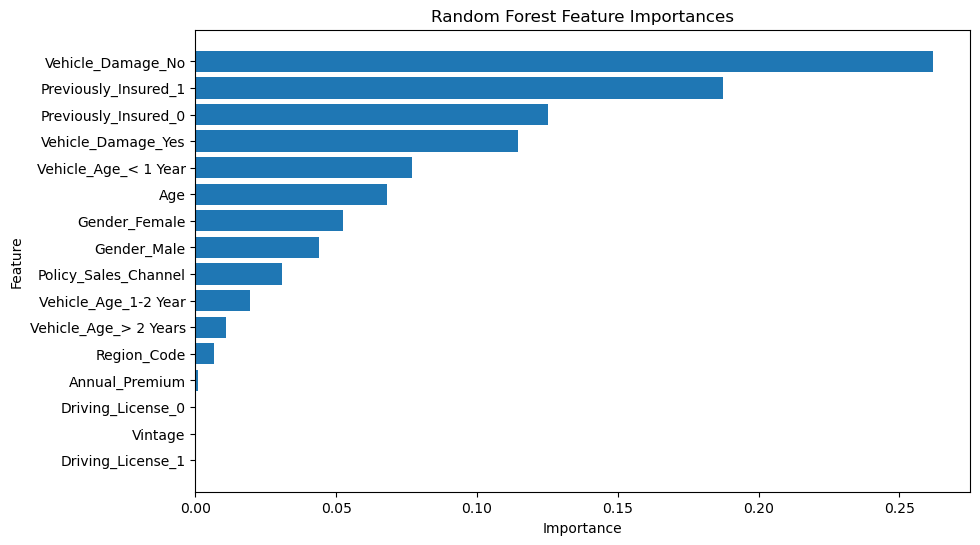

In [211]:
# Get the feature importances from the random forest model
rdf_importances = pd.DataFrame(
    {"Feature": data_copy2.columns, "Importance": best_rdf_model.feature_importances_}
).sort_values(by="Importance", ascending=True)

# Get the coefficients from the logistic regression model
plt.figure(figsize=(10, 6))
plt.barh(rdf_importances["Feature"], rdf_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

## More about model improvement

After finding the important features, we put them into a more complicated neuron network model. 

We scaled the data for neuron network as which can lead to faster convergence, prevent vanishing, improve numerical stability, ensure uniform feature influence, and provide a regularization effect. Scaling enhances the network's performance by reducing bias and increasing robustness to outliers and noise.

In [213]:
data_imp_features = data[
    [
        "Vehicle_Damage_No",
        "Age",
        'Vehicle_Age_< 1 Year',
        "Previously_Insured_0",
        "Previously_Insured_1",
        "Response",
        "Gender_Male",
        "Gender_Female",
        "Vehicle_Damage_Yes",
    ]
]

# Separate the response variable 'Response'
y = data_imp_features["Response"]
X = data_imp_features.drop(["Response"], axis=1)

data_imp_features = data_imp_features.drop(columns=["Response"])
# Standardize the numerical features
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_imp_features), columns=data_imp_features.columns
)
X_scaled = data_scaled

X_train_scaled, X_temp_scaled, y_train_scaled, y_temp_scaled = train_test_split(
    X_scaled, y, test_size=0.3, random_state=222
)
X_val_scaled, X_test_scaled, y_val_scaled, y_test_scaled = train_test_split(
    X_temp_scaled, y_temp_scaled, test_size=0.5, random_state=222
)

# Initialize SMOTE
smote = SMOTE(random_state=222)

# Fit SMOTE on the training data only
X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(
    X_train_scaled, y_train_scaled
)

In [244]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), max_iter=1000, random_state=222)

# Train the model
mlp_model = mlp.fit(X_train_smote_scaled, y_train_smote_scaled)
mlp_y_test_pred = mlp.predict(X_test_scaled)

print(
    "Multi-layer Classifier: \n", classification_report(y_test_scaled, mlp_y_test_pred)
)

Multi-layer Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.64      0.78     50176
           1       0.27      0.95      0.42      6991

    accuracy                           0.68     57167
   macro avg       0.63      0.79      0.60     57167
weighted avg       0.90      0.68      0.73     57167



# Comparing the neuron network results with the tuned Random Forest model


The Neural Network model has a higher recall for class 1 (0.95 vs 0.85), meaning it can correctly capture 10% more potential customers who will buy insurance.

The precision for class 1 is lower in the Neural Network model (0.27 vs 0.30), meaning the Neural Network model has a slightly higher rate of false positives (customers who were predicted to buy insurance but did not).

The overall accuracy is lower in the Neural Network model (0.68 vs 0.73), but as discussed previously, because the data is imbalanced, accuracy is not the best measure of model performance.

# Question 2: Suppose the Insurance company invests £1 Million in the Marketing department to boost their Advertisements. What is the best model can be use by the company to predict its targeted customers?(the cost of advertising per customer is uniform)

The Neural Network model is suggested because it offers the highest recall. Although this model may waste some advertising pounds on customers who ultimately decide against purchasing insurance (due to the lower precision), it will ensure that fewer potential customers are overlooked. This strategy would maximise the potential return on the advertising investment, particularly if the expense of losing a potential customer is high in comparison to the expense of advertising to a non-customer. Furthermore, company can pay more attention on these customer features vehicle damage, vehicle age, previous insurance record, customer age and gender when advertising.

Finally, the neuron network model potentially helps the company to save £69218 based on the test set.

In [264]:
from sklearn.metrics import confusion_matrix

# here the cost of advertising per customer is uniform and the budget is 1 million
total_budget = 1000000  # total advertising budget
total_customers = len(y_test)  # total number of customers in the test set

# Cost of advertising per customer
cost_per_customer = total_budget / total_customers
print("Average cost per customer: ", "£", np.round(cost_per_customer))

# For Random Forest Model
# False positives are the cases where the predicted the customer will buy insurance but they did not
# Calculate the cost spent on these false positives
rf_fp = confusion_matrix(y_test, y_pred)[0][1]  # false positives for Random Forest model
rf_fp_cost = rf_fp * cost_per_customer  # cost spent on false positives for Random Forest model

# For Neural Network Model
# Calculate the false positives first from the confusion matrix
nn_fp = confusion_matrix(y_test, mlp_y_test_pred)[0][1]  # false positives for Neural Network model
nn_fp_cost = nn_fp * cost_per_customer  # cost spent on false positives for Neural Network model

rf_fp_cost, nn_fp_cost, rf_fp_cost - nn_fp_cost  # cost difference between the two models
print("Amount of money saved: ", "£", np.round(np.abs(rf_fp_cost - nn_fp_cost)) )

Average cost per customer:  £ 17.0
Amount of money saved:  £ 69218.0


# Question 3. How many optimal customer segments can be defined? How does the company advertise for each segment?

#### We used k-means clustering to answer the question, each segment is equivalent to a cluster.

The distance between the points in a cluster is quantified by the inertia (with-sum-of-square-error(WSSE)) of a K-means model. It is calculated as the sum of the squares of the distances between each point in the cluster and its centroid. A lower inertia value, then, indicates that points are nearer to their respective centroids and that the clustering is therefore better. Thus, we selected the 6th cluster, where is at the elbow point. Because, the WSSE points after it does not have a big change.

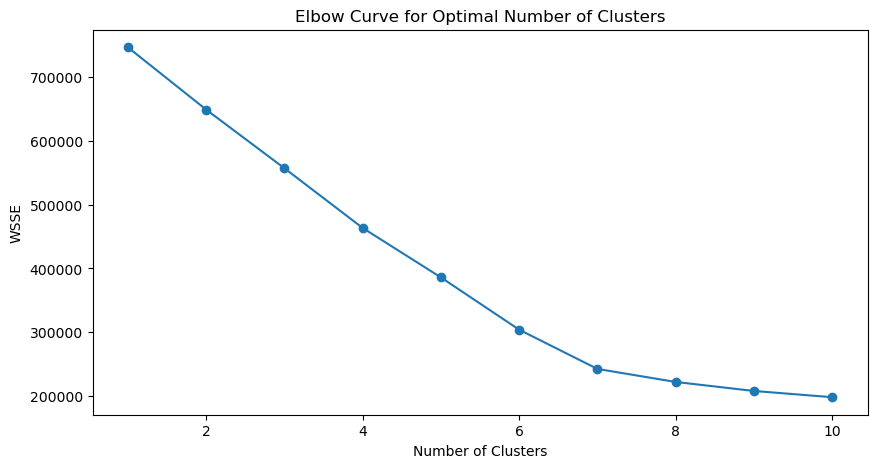

In [285]:
# Filter the data for customers who bought insurance
bought_insurance = data[data['Response'] == 1]

# Drop the 'Response' column as we're only interested in the features for clustering
bought_insurance_features = bought_insurance.drop('Response', axis=1)

# Standardize the data
scaler = StandardScaler()
bought_insurance_scaled = scaler.fit_transform(bought_insurance_features)

# Use the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_init=20, n_clusters=i, random_state=222)
    kmeans.fit(bought_insurance_scaled)
    inertia.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Curve for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WSSE')
plt.show()


In [274]:
kmeans = KMeans(n_init=20, n_clusters=6, random_state=222)
kmeans.fit(bought_insurance_scaled)

KMeans(n_clusters=6, n_init=20, random_state=222)

In [279]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=bought_insurance_features.columns)
cluster_centers_df

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Previously_Insured_0,Previously_Insured_1,Driving_License_0,Driving_License_1
0,0.187120,0.027853,0.021621,-0.125447,-0.005524,1.252438,-1.252438,0.346223,-0.426768,0.010773,-0.146543,0.146543,0.058259,-0.058259,-0.029640,0.029640
1,0.294372,-0.002491,0.025761,-0.149721,0.007448,-0.798443,0.798443,0.283102,-0.426499,0.101869,-0.146543,0.146543,0.058259,-0.058259,-0.029640,0.029640
2,1.285058,-0.164081,0.065225,-0.352972,-0.122509,-0.098142,0.098142,0.304968,-0.426957,0.070750,-0.146543,0.146543,0.058259,-0.058259,33.738232,-33.738232
3,-0.608055,-0.089543,-0.433199,0.527437,-0.018519,0.075999,-0.075999,-0.305347,0.647216,-0.334561,6.823943,-6.823943,0.058259,-0.058259,-0.029640,0.029640
4,-0.636000,-0.149593,-0.252778,0.565370,0.025567,0.006333,-0.006333,-0.330181,0.659657,-0.313526,3.029881,-3.029881,-17.164874,17.164874,-0.029640,0.029640
5,-1.364651,-0.034787,-0.074891,0.722743,-0.011983,0.130834,-0.130834,-1.709939,2.342157,-0.334561,-0.146543,0.146543,0.058259,-0.058259,-0.029640,0.029640


#  Interpretations and insights of the k-means

## These interpretations are based on the relative values of the features in each cluster center
• **Cluster 0** is characterized by slightly higher Age, predominantly Gender_Female, vehicles with Vehicle_Age_1-2 Year, less Vehicle_Damage_No, more Vehicle_Damage_Yes, and more Previously_Insured_0.

• **Cluster 1** is characterized by slightly higher Age, predominantly Gender_Male, vehicles with Vehicle_Age_1-2 Year, less Vehicle_Damage_No, more Vehicle_Damage_Yes, and more Previously_Insured_0.

• **Cluster 2** is characterized by significantly higher Age, balanced genders, vehicles with Vehicle_Age_1-2 Year, less Vehicle_Damage_No, more Vehicle_Damage_Yes, more Previously_Insured_0, and a significant absence of a Driving_License.

• **Cluster 3** is characterized by significantly lower Age, slightly more Gender_Female, vehicles mostly with Vehicle_Age_< 1 Year, significantly more Vehicle_Damage_No, less Vehicle_Damage_Yes, more Previously_Insured_1, and everyone in this cluster has a Driving_License.

• **Cluster 4** is characterized by slightly lower Age, balanced genders, vehicles mostly with Vehicle_Age_< 1 Year, significantly more Vehicle_Damage_No, less Vehicle_Damage_Yes, significantly more Previously_Insured_1, and everyone in this cluster has a Driving_License.

• **Cluster 5** is characterized by significantly lower Age, slightly more Gender_Female, vehicles mostly with Vehicle_Age_< 1 Year, less Vehicle_Damage_No, more Vehicle_Damage_Yes, more Previously_Insured_0, and everyone in this cluster has a Driving_License.

One of these groups, Cluster 1, is of particular interest to our advertising strategy. Customers in Cluster 1 are slightly older, primarily male, have vehicles that are one to two years old, have a history of vehicle damage, but have been insured throughout these incidents.

### For clients in Cluster 1, for instance, we advise the following specific advertising strategy given these characteristics:

**Customise the Advertising to Male Customers**: Since men make up the majority of this cluster, the advertising content should be created with men in mind. This might entail utilising language, themes, and imagery that are more likely to appeal to our male customers.

**Stress the Importance of Insurance Continuity:** Customers in this cluster have previously experienced vehicle damage but were still covered by insurance at the time. Given the relatively new age of their vehicles, our messaging should emphasise the advantages and significance of maintaining ongoing insurance coverage.

**Focus on the Protection of New Vehicles:** The advertisements should underscore how insurance can help protect and maintain the value of their relatively new vehicles. This can be done by highlighting the potential costs of repairs and replacements for newer model cars and how insurance coverage can mitigate these costs.

**Channel selection:** We can determine the most efficient channels to reach our slightly older male customers based on additional demographic and behavioural information we have on them. These could include more conventional channels like TV shows that are well-liked by this group, as well as digital ones like particular websites or social media platforms.



# Summary and challenges:

The cost of training the model is expensive as it requires a long duration of period to train the model. 

The machine learning model heavily relies on the quality of the data used to train them.

Neural networks are very complex and can be challenging to determine the appropriate architecture for a given problem.

Oversampling can also lead to overfitting if not done carefully. Hence, it’s important to evaluate the performance of the model on a separate validation set.

In conclusion, random forests are better at predicting the potential customers compared to the baseline model which is the Decision Tree. However, after tuning the Random forests, the new model now is better than the untuned Random forests. We obtained the top 8 important features and used them for neuron network. Then the neural network provides the best performance on predicting the potential customers who would purchase the insurance at 95%. Finally, we identified 6 optimal customer segments and their related characteristics by k-means, which are good for the company to perform targeted advertisements. 

